<h2><center>Data Analysis</center></h2>

In [1]:
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, MetaData, Table, Column, Float, Integer, String, extract, distinct, ForeignKey
from sqlalchemy.engine import reflection
from config import engine_url
import pandas as pd
import datetime as dt
from sqlalchemy.orm import relationship

In [2]:
engine = create_engine(engine_url)

In [3]:
# Ger connection to use with pandas
conn = engine.connect()

In [4]:
# Open session to use with sqlalchemy
session = Session(engine)

<h3>First at all, I use sqlalchemy to explore data using simple queries</h3>

In [5]:
metadata = MetaData()
metadata.reflect(engine, only=['employees', 'titles', 'departments', 'salaries'])

Table('dept_emp', metadata,
    Column('emp_no', Integer, primary_key=True),
    Column('dept_no', String, primary_key=True)
)

Table('dept_manager', metadata,
    Column('dept_no', String, primary_key=True),
    Column('emp_no', Integer, primary_key=True)
)

Base = automap_base(metadata=metadata)
Base.prepare()

In [6]:
Departments = Base.classes.departments
Dept_emp = Base.classes.dept_emp
Dept_manager = Base.classes.dept_manager
Employees = Base.classes.employees
Salaries = Base.classes.salaries
Titles = Base.classes.titles

In [7]:
# 1. List the following details of each employee: employee number, last name, first name, sex, and salary.
results = session.query(
    Employees.emp_no, 
    Employees.last_name, 
    Employees.first_name, 
    Employees.sex, 
    Employees.sex, 
    Salaries.salary
).filter(
    Employees.emp_no == Salaries.emp_no
).limit(10).all()

for result in results:
    print(result)

(10001, 'Facello', 'Georgi', 'M', 'M', 60117)
(10002, 'Simmel', 'Bezalel', 'F', 'F', 65828)
(10003, 'Bamford', 'Parto', 'M', 'M', 40006)
(10004, 'Koblick', 'Chirstian', 'M', 'M', 40054)
(10005, 'Maliniak', 'Kyoichi', 'M', 'M', 78228)
(10006, 'Preusig', 'Anneke', 'F', 'F', 40000)
(10007, 'Zielinski', 'Tzvetan', 'F', 'F', 56724)
(10008, 'Kalloufi', 'Saniya', 'M', 'M', 46671)
(10009, 'Peac', 'Sumant', 'F', 'F', 60929)
(10010, 'Piveteau', 'Duangkaew', 'F', 'F', 72488)


In [8]:
# 2. List first name, last name, and hire date for employees who were hired in 1986.
results = session.query(
    Employees.first_name, 
    Employees.last_name, 
    Employees.hire_date, 
).filter(
    extract('year', Employees.hire_date) == 1986
).limit(10).all()

for result in results:
    print(result)

('Eran', 'Cusworth', datetime.date(1986, 11, 14))
('Bojan', 'Zallocco', datetime.date(1986, 10, 14))
('Nevio', 'Demizu', datetime.date(1986, 5, 18))
('Ziva', 'Vecchi', datetime.date(1986, 7, 3))
('Mohit', 'Speek', datetime.date(1986, 1, 14))
('Qunsheng', 'Speer', datetime.date(1986, 2, 13))
('Dines', 'Encarnacion', datetime.date(1986, 8, 2))
('Harngdar', 'Swick', datetime.date(1986, 5, 28))
('Freyja', 'Uhrig', datetime.date(1986, 12, 20))
('Zhenhua', 'Milicic', datetime.date(1986, 8, 4))


In [9]:
# 3. List the department of each employee with the following information: 
#  employee number, last name, first name, and department name.
results = session.query(
    Employees.emp_no, 
    Employees.last_name, 
    Employees.first_name,
    Departments.dept_name
).filter(
    Dept_emp.dept_no == Departments.dept_no and 
    Dept_emp.emp_no == Employees.emp_no
).limit(10).all()

for result in results:
    print(result)

(473302, 'Zallocco', 'Hideyuki', 'Development')
(475053, 'Delgrande', 'Byong', 'Development')
(57444, 'Babb', 'Berry', 'Development')
(421786, 'Verhoeff', 'Xiong', 'Development')
(282238, 'Baumann', 'Abdelkader', 'Development')
(263976, 'Cusworth', 'Eran', 'Development')
(273487, 'Parfitt', 'Christoph', 'Development')
(461591, 'Samarati', 'Xudong', 'Development')
(477657, 'Magliocco', 'Lihong', 'Development')
(219881, 'Speek', 'Kwangyoen', 'Development')


In [10]:
session.close()

<h3>Secondly, I use queries directly into pandas to explore data using more complex queries</h3>

In [11]:
# 4. List the manager of each department with the following information: 
#  department number, department name, the manager's employee number, last name, first name.
data_4 = pd.read_sql("""
    SELECT d.dept_no, d.dept_name, dp.emp_no, e.last_name , e.first_name 
    FROM dept_manager dp
        JOIN departments d ON d.dept_no = dp.dept_no 
        JOIN employees e ON e.emp_no = dp.emp_no; """, conn)

data_4.head(3)

,dept_no,dept_name,emp_no,last_name,first_name
0,d001,Marketing,110022,Markovitch,Margareta
1,d001,Marketing,110039,Minakawa,Vishwani
2,d002,Finance,110085,Alpin,Ebru


In [12]:
# 5. List first name, last name, and sex for employees whose first name is "Hercules" and last names begin with "B."
data_5 = pd.read_sql("""
    SELECT first_name, last_name, sex    
    FROM employees
    WHERE first_name = 'Hercules' AND last_name LIKE 'B%'; """, conn)

data_5.head(3)

,first_name,last_name,sex
0,Hercules,Baer,M
1,Hercules,Biron,F
2,Hercules,Birge,F


In [13]:
# 6. List all employees in the Sales department, including their employee number, last name, first name, and department name.
data_6 = pd.read_sql("""
    SELECT e.emp_no, e.first_name, e.last_name, d.dept_name 
    FROM employees e
        JOIN dept_emp de ON de.emp_no = e.emp_no 
        JOIN departments d ON d.dept_no = de.dept_no 
    WHERE d.dept_name = 'Sales';  """, conn)

data_6.head(3)

,emp_no,first_name,last_name,dept_name
0,10002,Bezalel,Simmel,Sales
1,10016,Kazuhito,Cappelletti,Sales
2,10034,Bader,Swan,Sales


In [14]:
# 7. List all employees in the Sales and Development departments, including their 
#    employee number, last name, first name, and department name.
data_7 = pd.read_sql("""
    SELECT e.emp_no, e.last_name, e.first_name, d.dept_name 
    FROM employees e
        JOIN dept_emp de ON de.emp_no = e.emp_no 
        JOIN departments d ON d.dept_no = de.dept_no 
    WHERE d.dept_name IN('Sales', 'Development');  """, conn)

data_7.head(3)

,emp_no,last_name,first_name,dept_name
0,10001,Facello,Georgi,Development
1,10002,Simmel,Bezalel,Sales
2,10006,Preusig,Anneke,Development


In [15]:
# 8. In descending order, list the frequency count of employee last names, i.e., how many employees share each last name.
data_8 = pd.read_sql("""
    SELECT COUNT(last_name), last_name     
    FROM employees
        GROUP BY last_name 
        ORDER BY COUNT(last_name) DESC; """, conn)

data_8.head(4)

,count,last_name
0,226,Baba
1,223,Gelosh
2,223,Coorg
3,222,Sudbeck


<h3>Bonus</h3>

array([[<AxesSubplot:title={'center':'salary'}>]], dtype=object)

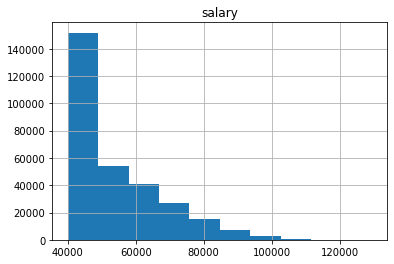

In [16]:
# Create a histogram to visualize the most common salary ranges for employees.
pd_hist = pd.read_sql("""
    SELECT salary    
    FROM salaries; """, conn)

pd_hist.hist()

In [17]:
# Create a bar chart of average salary by title.
pd_salaries = pd.read_sql("""
    SELECT t.title, s.salary 
    From employees e 
        JOIN titles t ON e.emp_title_id = t.title_id 
        JOIN salaries s ON e.emp_no = s.emp_no; """, conn)

pd_salaries.head(3)

,title,salary
0,Engineer,48973
1,Senior Engineer,40000
2,Technique Leader,43548


In [18]:
pd_avg_salary = pd_salaries.groupby("title").agg("mean").reset_index()
pd_avg_salary.head(10)

,title,salary
0,Assistant Engineer,48564.434447
1,Engineer,48535.336511
2,Manager,51531.041667
3,Senior Engineer,48506.799871
4,Senior Staff,58550.172704
5,Staff,58465.382850
6,Technique Leader,48582.896092


<AxesSubplot:xlabel='title'>

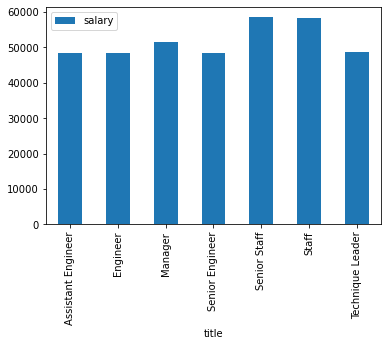

In [19]:
pd_avg_salary.plot.bar(x='title', y='salary')

In [20]:
# Evidence in hand, you march into your boss's office and present the visualization. 
#   With a sly grin, your boss thanks you for your work. On your way out of the office, you hear the words, 
#   "Search your ID number." You look down at your badge to see that your employee ID number is 499942.

pd_me = pd.read_sql("""
    SELECT salary 
    From salaries 
    WHERE emp_no = 499942; """, conn)

pd_me.head(3)

,salary
0,40000
